### p-y for sand

In [147]:
from dlpkg.cpt import CPT
from pathlib import Path
import os
import plotly.io as pio
import numpy as np
import pandas as pd
from numpy import degrees, log10, pi, radians, tan, sin, cos
import p_y_sand

In [148]:
filename ='CPT4.A00'
fileloc = Path(r'G:\Name Folders\Current Staff\CC213\10 IiA funding\Unified CPT Methods\01 Data\CPT Data\18 0091 05 R002 CPT ASCII')

cpt_data = CPT()
cpt_data.read_ASCII(fileloc / filename,key='Data--',pattern= r'(.{7})(.{10})(.{11})(.{11})(.{11})(.{11})(.{11})')
cpt_data.update_data_column_name(['Reading','SCPT_DPTH','SCPT_RES','SCPT_FRES','SCPT_PWP2','slopex','slopey'])
cpt_data.set_data_unit(['MPa','MPa','MPa'])
cpt_data.init_CPT()

23-10-16 17:41:19 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\dlpkg\cpt.py:327 DEBUG - Data unit is set to ['MPa', 'MPa', 'MPa']
c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\dlpkg\cpt.py:591: RuntimeWarning:

invalid value encountered in log10

23-10-16 17:41:21 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\dlpkg\cpt.py:156 DEBUG - qt calculated using net area ratio of 0.85


In [149]:
cpt_data.df ['phi_e'] = cpt_data.df.apply(lambda row:p_y_sand.calc_phi_e(qt = row['qt'], sigma_v = row['sigma_v'], sigma_v_e = row['sigma_v_e']), axis = 1)
cpt_data.df ['C1'] = cpt_data.df.apply(lambda row:p_y_sand.calc_C1(phi_e = row['phi_e']), axis = 1)
cpt_data.df ['C2'] = cpt_data.df.apply(lambda row:p_y_sand.calc_C2(phi_e = row['phi_e']), axis = 1)
cpt_data.df ['C3'] = cpt_data.df.apply(lambda row:p_y_sand.calc_C3(phi_e = row['phi_e']), axis = 1)
cpt_data.df ['k'] = cpt_data.df.apply(lambda row:p_y_sand.calc_k(phi_e = row['phi_e']), axis = 1)

c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\p_y_sand.py:14: RuntimeWarning:

invalid value encountered in log10



In [150]:
cpt_data.df ['pr'] = cpt_data.df.apply(lambda row:p_y_sand.calc_pr(D = 2.032, gamma = row['gamma'], z = row['SCPT_DPTH'], C1 = row['C1'], C2 = row['C2'], C3 = row['C3']), axis = 1)
cpt_data.df ['A'] = cpt_data.df.apply(lambda row:p_y_sand.calc_A(D = 2.0, z = row['SCPT_DPTH'], loading = 'Monotonic'), axis = 1)

In [180]:
# Generate p-y curves using specified y values
for i in range(11):
    cpt_data.df[f'y{i}'] = 10 * i
    cpt_data.df[f'p{i}'] = cpt_data.df.apply(lambda row:p_y_sand.calc_p(y = row[f'y{i}'], A = row['A'], pr = row['pr'], z = row['SCPT_DPTH'], k = row['k']), axis = 1)

In [157]:
cpt_data.df

,Reading,SCPT_DPTH,SCPT_RES,SCPT_FRES,SCPT_PWP2,slopex,slopey,qt,Rf,gamma,...,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
0,937,0.000,0.0000,NaN,NaN,5.7398,5.9407,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,938,0.007,0.0012,NaN,NaN,5.7493,5.9575,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,939,0.015,0.0014,NaN,0.1,5.7568,5.9609,0.001415,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,940,0.022,0.0020,NaN,0.2,5.7479,5.9625,0.002030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,941,0.030,0.0033,NaN,0.4,5.7262,5.9470,0.003360,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7446,12036,74.256,36.9960,171.1,603.0,9.5273,7.1031,37.086450,0.461354,20.267859,...,23333.729304,44236.120115,61193.573714,73878.342818,82802.676593,88813.938687,92745.205955,95266.774445,96864.064918,97867.877559
7447,12037,74.265,37.1310,173.4,613.4,9.5384,7.0817,37.223010,0.465841,20.284611,...,23397.936622,44364.137810,61382.611422,74121.975110,83091.732893,89138.463134,93096.085567,95636.535594,97247.003324,98259.841707
7448,12038,74.271,37.4581,174.4,599.5,9.5219,7.0552,37.548025,0.464472,20.294550,...,23541.285515,44638.129065,61765.869980,74590.146489,83622.137460,89712.520364,93699.816651,96260.005054,97883.410521,98904.645688
7449,12039,74.280,37.4564,178.2,608.9,9.5449,7.0422,37.547735,0.474596,20.319316,...,23546.292911,44658.330458,61814.170461,74674.762647,83744.329083,89868.400524,93883.179351,96464.415757,98103.264729,99135.500068


In [182]:
# Export data to execl
#cpt_data.df.loc[:, ['SCPT_DPTH']]
df = cpt_data.df
depth = df[df['SCPT_DPTH'] == 1.001]
print(depth)
writer = pd.ExcelWriter('data.xlsx')
df.to_excel(writer, sheet_name='Sheet 1')
writer.save()

     Reading  SCPT_DPTH  SCPT_RES  SCPT_FRES  SCPT_PWP2  slopex  slopey  \
127     1127      1.001    0.0821        0.7       30.2  6.4661  5.5488   

          qt        Rf      gamma  ...  p1  p2  p3  p4  p5  p6  p7  p8  p9  \
127  0.08663  0.808034  11.627785  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN   

     p10  
127  NaN  

[1 rows x 51 columns]


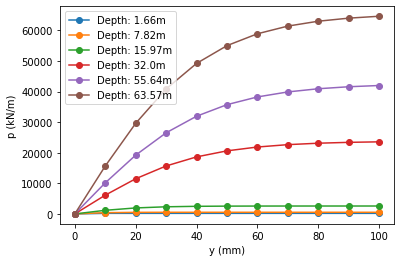

In [183]:
# Plot p-y curves at desiganated depths
import matplotlib.pyplot as plt

# Select the 10th row and extract the desired columns
#row = cpt_data.df.iloc[1999]

# Specify the rows to plot
rows_to_plot = [200, 800, 1600, 3200, 5600, 6400]

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the selected rows
for i in rows_to_plot:
    row = df.iloc[i]
    x = [row[f'y{j}'] for j in range(11)]
    y = [row[f'p{j}'] for j in range(11)]
    depth = round(row['SCPT_DPTH'], 2)
    ax.plot(x, y, '-o', label=f'Depth: {depth}m')

# Add labels and legend
ax.set_xlabel('y (mm)')
ax.set_ylabel('p (kN/m)')
ax.legend()

# Show the plot
plt.show()